In [11]:
!git clone https://bitbucket.org/jadslim/german-traffic-signs

Cloning into 'german-traffic-signs'...
Receiving objects: 100% (6/6), 117.80 MiB | 16.37 MiB/s, done.
Updating files: 100% (4/4), done.


In [10]:
!dir german-traffic-signs

dir: cannot access 'german-traffic-signs': No such file or directory


In [4]:
import cv2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Flatten, Dropout
from keras.utils import to_categorical
from keras.layers import Conv2D, MaxPooling2D
import random
import pickle
from keras.callbacks import LearningRateScheduler, ModelCheckpoint
%matplotlib inline

In [9]:
np.random.seed(0)

In [12]:
#TODO: Implement load the data here.
with open('german-traffic-signs/train.p', 'rb') as f:
    train_data = pickle.load(f)
with open('german-traffic-signs/valid.p', 'rb') as f:
    val_data = pickle.load(f)
# TODO: Load test data
with open('german-traffic-signs/test.p', 'rb') as f:
    test_data = pickle.load(f)

In [13]:
# Split out features and labels
X_train, y_train = train_data['features'], train_data['labels']
X_val, y_val = val_data['features'], val_data['labels']
X_test, y_test = test_data['features'], test_data['labels']

In [14]:
#already 4 dimensional
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(34799, 32, 32, 3)
(12630, 32, 32, 3)
(4410, 32, 32, 3)


In [15]:
# STOP: Do not change the tests below. Your implementation should pass these tests.
assert(X_train.shape[0] == y_train.shape[0]), "The number of images is not equal to the number of labels."
assert(X_train.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_val.shape[0] == y_val.shape[0]), "The number of images is not equal to the number of labels."
assert(X_val.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."
assert(X_test.shape[0] == y_test.shape[0]), "The number of images is not equal to the number of labels."
assert(X_test.shape[1:] == (32,32,3)), "The dimensions of the images are not 32 x 32 x 3."

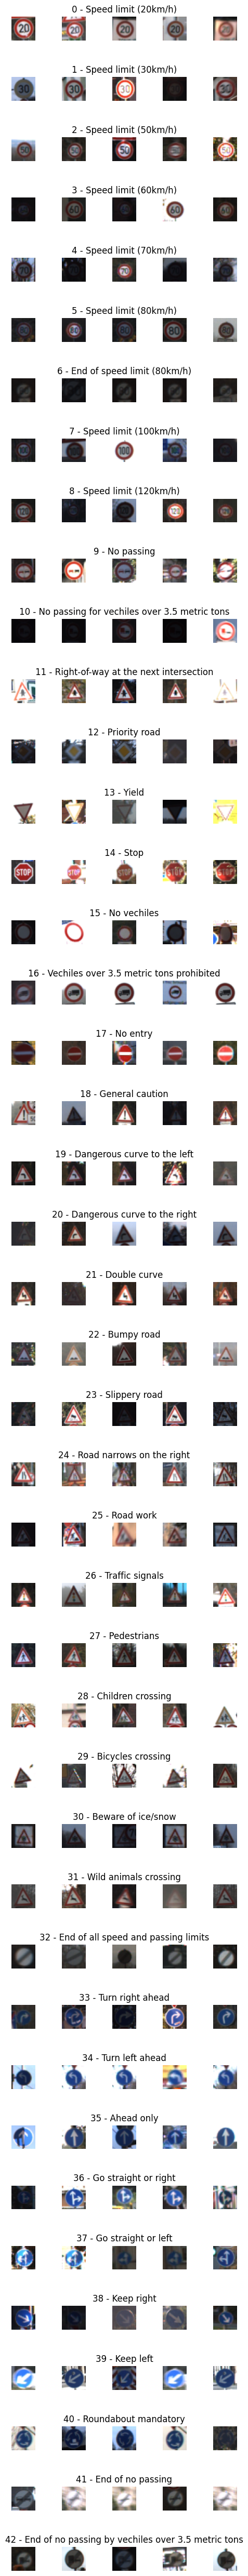

In [16]:
data = pd.read_csv('german-traffic-signs/signnames.csv')

num_of_samples=[]

cols = 5
num_classes = 43

fig, axs = plt.subplots(nrows=num_classes, ncols=cols, figsize=(5,50))
fig.tight_layout()

for i in range(cols):
    for j, row in data.iterrows():
        x_selected = X_train[y_train == j]
        axs[j][i].imshow(x_selected[random.randint(0,(len(x_selected) - 1)), :, :], cmap=plt.get_cmap('gray'))
        axs[j][i].axis("off")
        if i == 2:
          axs[j][i].set_title(str(j) + " - " + row["SignName"])
          num_of_samples.append(len(x_selected))

[180, 1980, 2010, 1260, 1770, 1650, 360, 1290, 1260, 1320, 1800, 1170, 1890, 1920, 690, 540, 360, 990, 1080, 180, 300, 270, 330, 450, 240, 1350, 540, 210, 480, 240, 390, 690, 210, 599, 360, 1080, 330, 180, 1860, 270, 300, 210, 210]


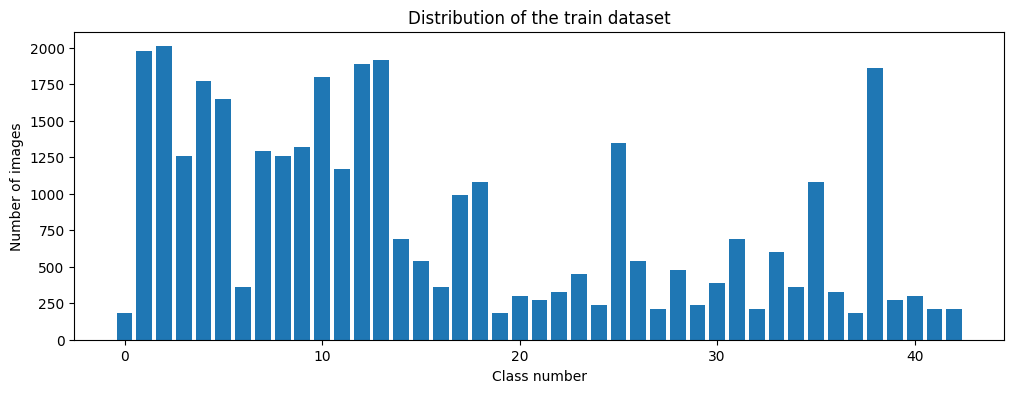

In [17]:
print(num_of_samples)
plt.figure(figsize=(12, 4))
plt.bar(range(0, num_classes), num_of_samples)
plt.title("Distribution of the train dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

(32, 32, 3)
36


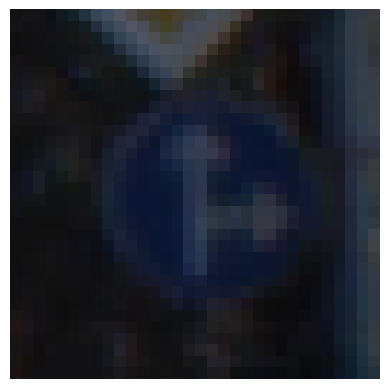

In [18]:
plt.imshow(X_train[1000])
plt.axis("off")
print(X_train[1000].shape)
print(y_train[1000])

(32, 32)


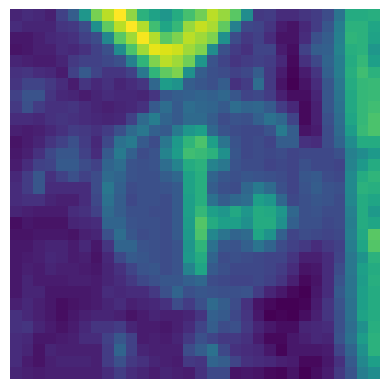

In [19]:
def grayscale(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return img

img = grayscale(X_train[1000])
plt.imshow(img)
plt.axis("off")
print(img.shape)

(32, 32)


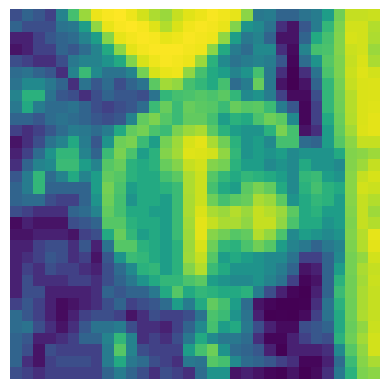

In [20]:
def equalize(img):
    img = cv2.equalizeHist(img)
    return img

img = equalize(img)
plt.imshow(img)
plt.axis("off")
print(img.shape)

In [21]:
def preprocess(img):
    img = grayscale(img)
    img = equalize(img)
    img = img/255
    return img

X_train = np.array(list(map(preprocess, X_train)))
X_test = np.array(list(map(preprocess, X_test)))
X_val = np.array(list(map(preprocess, X_val)))

(34799, 32, 32)


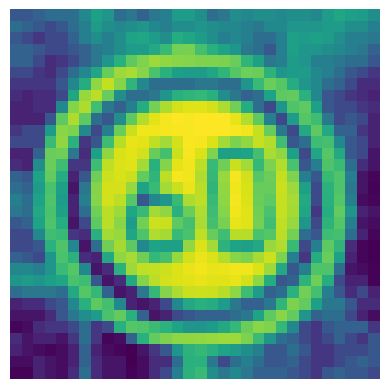

In [22]:
plt.imshow(X_train[random.randint(0, len(X_train) - 1)])
plt.axis('off')
print(X_train.shape)

In [23]:
X_train = X_train.reshape(34799, 32, 32, 1)
X_test = X_test.reshape(12630, 32, 32, 1)
X_val = X_val.reshape(4410, 32, 32, 1)

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(width_shift_range=0.1,
                             height_shift_range=0.1,
                             zoom_range=0.2, shear_range=0.1, rotation_range=10.)
datagen.fit(X_train)

(15, 32, 32, 1)


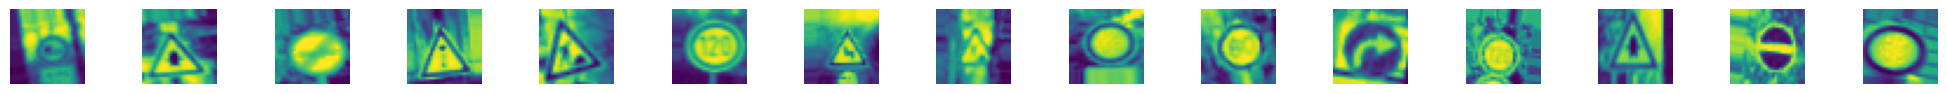

In [25]:
# for X_batch, y_batch in

batches = datagen.flow(X_train, y_train, batch_size = 15)
X_batch, y_batch = next(batches)

fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()

for i in range(15):
    axs[i].imshow(X_batch[i].reshape(32, 32))
    axs[i].axis("off")

print(X_batch.shape)

In [26]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)
y_val = to_categorical(y_val, 43)

In [31]:
# create model

def modified_model():
  model = Sequential()
  model.add(Conv2D(60, (5, 5), input_shape=(32, 32, 1), activation='relu'))
  model.add(Conv2D(60, (5, 5), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(Conv2D(30, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))

  model.add(Flatten())
  model.add(Dense(500, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(43, activation='softmax'))

  model.compile(Adam(learning_rate = 0.001), loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [32]:
model = modified_model()
print(model.summary())

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 10, 10, 30)     │        16,230 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 8, 8, 30)       │         8,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 30)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 480)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 500)            │       240,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 43)             │        21,543 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 378,023 (1.44 MB)

 Trainable params: 378,023 (1.44 MB)

 Non-trainable params: 0 (0.00 B)

None


In [33]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=50),
                    steps_per_epoch=2000, epochs=10,
                    validation_data=(X_val, y_val), shuffle = 1)

Epoch 1/10
 696/2000 ━━━━━━━━━━━━━━━━━━━━ 30s 24ms/step - accuracy: 0.2864 - loss: 2.6210

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


2000/2000 ━━━━━━━━━━━━━━━━━━━━ 24s 9ms/step - accuracy: 0.4194 - loss: 2.0830 - val_accuracy: 0.9104 - val_loss: 0.3485
Epoch 2/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 33s 7ms/step - accuracy: 0.7997 - loss: 0.6514 - val_accuracy: 0.9535 - val_loss: 0.1632
Epoch 3/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.8763 - loss: 0.3938 - val_accuracy: 0.9667 - val_loss: 0.1073
Epoch 4/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9079 - loss: 0.2900 - val_accuracy: 0.9730 - val_loss: 0.0785
Epoch 5/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - accuracy: 0.9261 - loss: 0.2366 - val_accuracy: 0.9830 - val_loss: 0.0564
Epoch 6/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step - accuracy: 0.9355 - loss: 0.2091 - val_accuracy: 0.9846 - val_loss: 0.0482
Epoch 7/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 19s 7ms/step - accuracy: 0.9474 - loss: 0.1701 - val_accuracy: 0.9816 - val_loss: 0.0524
Epoch 8/10
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - accuracy: 0.9514 - loss: 0.1602 - val

Text(0.5, 0, 'epoch')

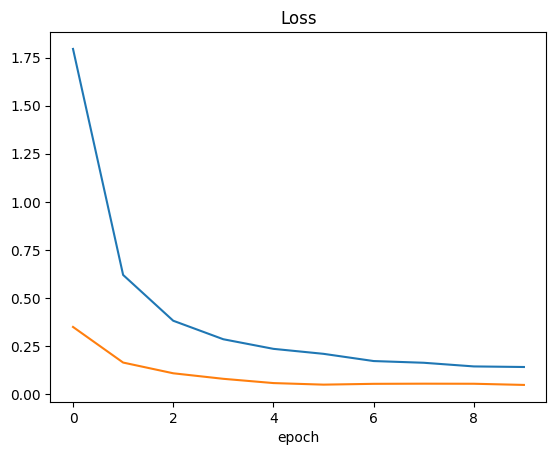

In [34]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss')
plt.xlabel('epoch')

Text(0.5, 0, 'epoch')

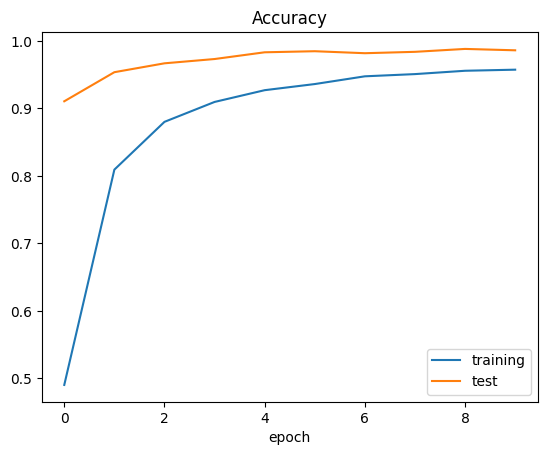

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training','test'])
plt.title('Accuracy')
plt.xlabel('epoch')

In [38]:
# TODO: Evaluate model on test data
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Test score: 0.17350438237190247
Test accuracy: 0.9548693299293518


(32, 32)


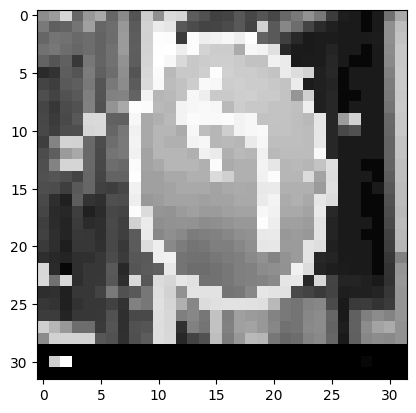

In [44]:
#predict internet number
import requests
from PIL import Image
url = 'https://c8.alamy.com/comp/A0RX23/cars-and-automobiles-must-turn-left-ahead-sign-A0RX23.jpg'
r = requests.get(url, stream=True)
img = Image.open(r.raw)
plt.imshow(img, cmap=plt.get_cmap('gray'))

img = np.asarray(img)
img = cv2.resize(img, (32, 32))
img = preprocess(img)
plt.imshow(img, cmap = plt.get_cmap('gray'))
print(img.shape)

In [46]:
img = img.reshape(1, 32, 32, 1)
prediction = model.predict(img)
predicted_class = np.argmax(prediction, axis=1)
print("Predicted Sign: ", predicted_class[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Predicted Sign:  38
